In [12]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
matplotlib.rc('font', size=20)
matplotlib.rc('axes', titlesize=20)
matplotlib.rc('axes', labelsize=20)
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('legend', fontsize=20)
matplotlib.rc('figure', titlesize=20)

In [8]:
data = pd.read_csv("/Users/sominwadhwa/Work/Kaggle_Data/Quora/train.csv")
data.ix[np.random.choice(data.index,2 10)]

,id,qid1,qid2,question1,question2,is_duplicate
350559,350559,479311,479312,Promotion at IT MNC India : I am a very good p...,I am currently working as a performance engine...,0
376939,376939,175441,508151,"How do liberals feel about Trump saving 10,000...",What major misconceptions do conservatives hav...,0
147045,147045,232144,232145,Is the density of canola oil affected by press...,How can the density of canola oil affect its q...,0
49325,49325,87799,87800,How do I start learning about stock market?,How do we start learning stock market?,1
70819,70819,121979,121980,What shall I do when everything goes wrong?,What do I do when everything goes wrong?,1
276743,276743,170671,278329,Why Do Olympians Bite Their Medals?,Why do olympians bite medal after they win it?,1
263716,263716,380307,277232,What are some simple math tricks that you can ...,What are some useful math tricks in daily life?,1
359110,359110,488713,488714,How rare is the mythical 10x software engineer?,What's a first second and third level domain n...,0
198556,198556,299807,299808,Could someone tell of a James Ronsey (misspell...,What are the best instructions about fin heat ...,0
223118,223118,330862,330863,What are the best areas to invest with 100K in...,How should I invest 100k-150k at age 30 living...,0


In [11]:
data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


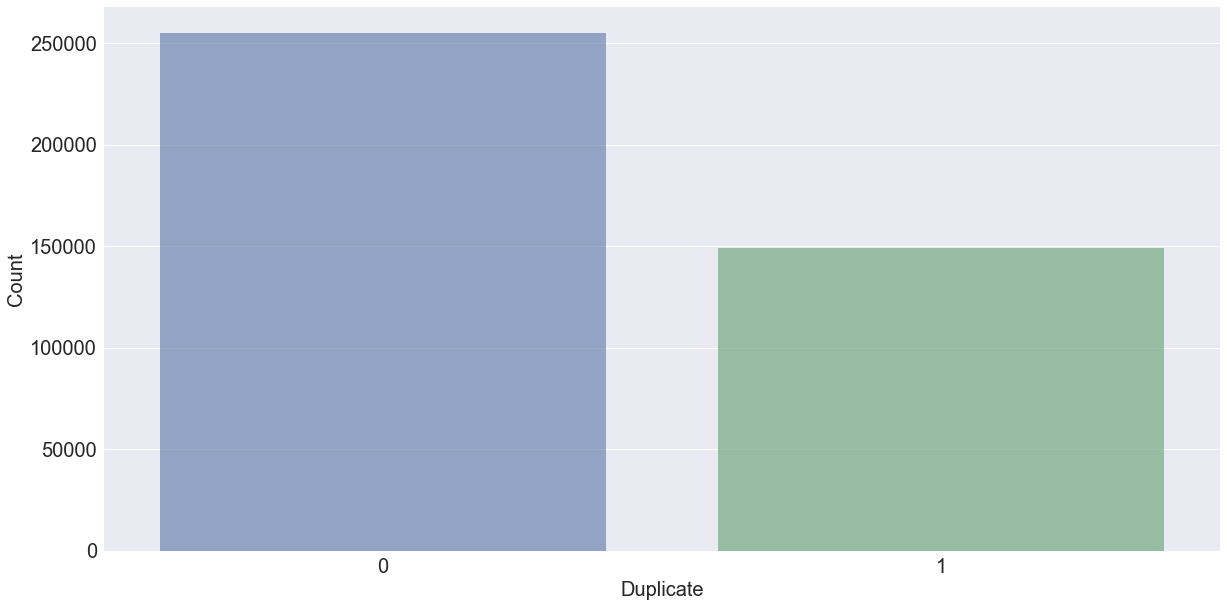

In [48]:
plt.figure(figsize=(20,10))
data_by_count = data.groupby('is_duplicate', as_index=False).id.count()
sns.barplot(data=data_by_count, x='is_duplicate', y='id', alpha=0.6)
plt.xlabel("Duplicate")
plt.ylabel("Count")

In [33]:
from collections import Counter
import operator
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import multiprocessing
import difflib
from sklearn.cross_validation import train_test_split
import xgboost as xgb

### Approach
0. Do simple Cosine/Jaccard similarity check w/o any semantic analysis whatsoever
1. Check for similarities in Test/Training Data
2. Create a list of all questions under one list
3. Do EDA - Word/Char Count Hist (labelling-dup or not), correlation, semantic analysis
4. Improvise with TF-IDF
5. Test different predictive models- Logistic, XGB etc with supporting ROC/P-R curves

In [42]:
stop = stopwords.words('english')

In [43]:
data = data.dropna()
data['question1'] = data['question1'].apply(lambda x: x.rstrip('?'))
data['question2'] = data['question2'].apply(lambda x: x.rstrip('?'))
data['question1'] = data['question1'].str.lower().str.split()
data['question2'] = data['question2'].str.lower().str.split()
data['question1'] = data['question1'].apply(lambda x: [item for item in x if item not in stop])
data['question2'] = data['question2'].apply(lambda x: [item for item in x if item not in stop])

In [45]:
data.ix[np.random.choice(data.index, 10)]

,id,qid1,qid2,question1,question2,is_duplicate
45320,45320,81235,81236,"[following, professions, average, financially,...","[profession, better, chartered, accountant, so...",0
363592,363592,493599,493600,"[diet, us, president, restricted, protocols]","[us, presidents, alive]",0
75769,75769,129615,129616,"[hierarchy, mckinsey, company]","[hierarchy, mckinsey, &, company]",1
249159,249159,362717,362718,"[best, chess, tutorials, beginners]","[best, books, beginner, chess, player]",0
227779,227779,336697,18180,"[sell, sarees, online]","[start, online, store]",0
305396,305396,428801,428802,"[many, countries, national, flag, eagle]","[time, national, flags, get, abolished]",0
386073,386073,11034,68603,"[solution, kashmir, problem]","[think, best, solution, kashmir, issue]",1
16570,16570,31582,31583,"[play, game, files, downloaded, ocean, games]","[get, old, snapchat, stories, back]",0
129265,129265,207688,207689,"[tall, empire, state, building, new, york, city]","[tall, empire, state]",1
339851,339851,467534,116615,"[best, photograph, government, corruption, india]","[best, photograph, government, corruption]",0


In [46]:
data['Common'] = data.apply(lambda row: len(list(set(row['question1']).intersection(row['question2']))), axis=1)
data['Average'] = data.apply(lambda row: 0.5*(len(row['question1'])+len(row['question2'])), axis=1)
data['Percentage'] = data.apply(lambda row: row['Common']*100.0/(row['Average']+1), axis=1)

In [47]:
data.ix[np.random.choice(data.index,10)]

,id,qid1,qid2,question1,question2,is_duplicate,Common,Average,Percentage
107688,107688,177110,177111,"[best, money, making, app, click, call]","[app, best, making, money]",0,4,5.0,66.666667
291974,291974,160,12132,"[what's, purpose, life?, life, actually]","[according, purpose, life]",1,2,4.0,40.000000
101961,101961,168793,168794,"[best, laptop, rs, 150000, india]","[best, laptop, buy, rs., 1,00,000, india]",0,3,5.5,46.153846
307366,307366,431035,431036,"[strongest, power, world, around, 1750]","[strongest, wall, world]",0,2,4.0,40.000000
264594,264594,82929,381398,"[harm, taking, antibiotics, haphazardly, 2, we...","[japanese, girlfriend, 2.5, years, working, va...",0,2,15.5,12.121212
46786,46786,83631,83632,"[people, furious, eating, dogs, beef,, pork,, ...","[many, people, eating, dog, meat,, eating, por...",1,5,8.0,55.555556
137545,137545,86342,137719,"[get, better, math]","[become, good, math]",1,1,3.0,25.000000
206125,206125,23375,309462,"[references, pokemon, red, blue, pokemon, xy]","[what's, biggest, mystery/secret, pokémon, red...",0,0,5.5,0.000000
110149,110149,4125,180657,"[epic,, funniest, farewell, emails, ever, sent...","[make, farewell, speech, personal, emotional]",0,1,7.0,12.500000
340376,340376,291038,61542,"[causes, cure, diabetics]","[causes, diabetes]",1,1,2.5,28.571429


## Studying Cosine Similarity

In [53]:
import math,re

In [54]:
def get_cosine(vec1, vec2):
    vec1 = Counter(vec1)
    vec2 = Counter(vec2)
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])
    sum1 = sum([vec1[x]**2 for x in vec1.keys()])
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)
    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator

In [55]:
data['cosine'] = data.apply(lambda row: get_cosine(row['question1'], row['question2']), axis=1)

In [56]:
data.ix[np.random.choice(data.index,10)]

,id,qid1,qid2,question1,question2,is_duplicate,Common,Average,Percentage,cosine
155664,155664,79986,93338,"[best, advice, you've, received]","[what's, best, parenting, advice]",0,2,4.0,40.000000,0.500000
46238,46238,82731,82732,"[things, still, don't, know, bacteria]","[things, still, don't, know]",0,4,4.5,72.727273,0.894427
382342,382342,223549,514186,"[oversleep, work?, take, urgent, leave]","[one, avoid, oversleeping, studying]",0,0,4.5,0.000000,0.000000
73588,73588,126266,29858,"[telltale, signs, guy, still, likes]","[find, guy, interested]",0,1,4.0,20.000000,0.258199
357832,357832,487241,487242,"[best, way, get, real, estate, license, texas]","[get, real, estate, license, texas]",1,5,6.0,71.428571,0.845154
7604,7604,11392,14850,"[think, modi's, sudden, decision, scrap, 500, ...","[what's, opinion, indian, prime, minister, mod...",1,3,11.0,25.000000,0.277350
315515,315515,214702,440419,"[handsome, anime, male, characters]","[beautiful, female, characters, anime]",0,2,4.0,40.000000,0.500000
388748,388748,521185,521186,"[wikileaks:, jacob, appelbaum]","[wikileaks, crime]",0,0,2.5,0.000000,0.000000
81876,81876,30894,138947,"[interesting, thing, ever, happened]","[someone, best, thing, worst, thing, happened]",1,2,5.0,33.333333,0.530330
26448,26448,49224,49225,"[epfs, india, apis, purpose, checks, balances]","[equivalent, $_post, (php), java]",0,0,5.0,0.000000,0.000000


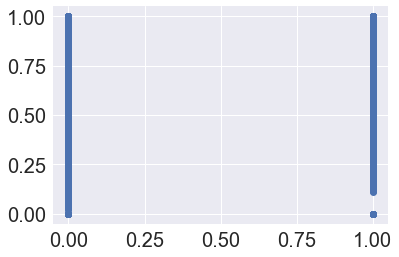

In [59]:
plt.plot(data['is_duplicate'], data['cosine'],'o')

## Jaccard Similarity

In [60]:
data['Jaccard'] = data.apply(lambda row: 0 if (len(row['question1'])+len(row['question2'])-row['Common']) == 0  else float(row['Common'])/((len(row['question1'])+len(row['question2'])-row['Common'])), axis=1)
data.ix[np.random.choice(data.index,10)]

,id,qid1,qid2,question1,question2,is_duplicate,Common,Average,Percentage,cosine,Jaccard
266155,266155,135335,383281,"[stop, comparing, others]","[stop, comparing, life, people, better]",1,2,4.0,40.000000,0.516398,0.333333
309933,309933,433982,433983,"[percentage, people, using, quora, ever, heard...","[food, additives, use, carrier, agent, dissolv...",0,0,8.0,0.000000,0.000000,0.000000
377494,377494,508797,296163,"[could, someone, provide, reading, materials, ...","[universe, expanding, first, time]",0,0,6.5,0.000000,0.000000,0.000000
91719,91719,153648,153649,"[best, pair, studio, monitors, $220]","[best, studio, monitors, $450, per, pair]",0,4,5.5,61.538462,0.730297,0.571429
111743,111743,130032,182957,"[best, get, started, freelancing, web, develop...","[start, freelancing, web, developer]",1,3,7.0,37.500000,0.668153,0.272727
381435,381435,12346,324941,"[good, anime, movies]","[best, animated, movie, you've, ever, watched]",0,0,4.5,0.000000,0.000000,0.000000
21006,21006,39584,39585,"[zagat, yelp, ratings, compare]","[doesn't, google, make, zagat, completely, free]",0,1,5.0,16.666667,0.204124,0.111111
162497,162497,252958,122168,"[best, hindi, songs, karaoke]","[best, hindi, songs]",0,3,3.5,66.666667,0.866025,0.750000
256646,256646,62262,278979,"[deal, stress]","[deal, stress]",1,2,2.0,66.666667,1.000000,1.000000
265015,265015,201193,381913,"[interesting, topics, new, users, follow]","[keep, track, interesting, content, topics, fo...",0,2,5.5,30.769231,0.365148,0.222222


In [62]:
data_test = pd.read_csv("/Users/sominwadhwa/Work/Kaggle_Data/Quora/test.csv")

In [64]:
data_test = data_test.dropna()
data_test['question1'] = data_test['question1'].apply(lambda x: x.rstrip('?'))
data_test['question2'] = data_test['question2'].apply(lambda x: x.rstrip('?'))
data_test['question1'] = data_test['question1'].str.lower().str.split()
data_test['question2'] = data_test['question2'].str.lower().str.split()
data_test['question1'] = data_test['question1'].apply(lambda x: [item for item in x if item not in stop])
data_test['question2'] = data_test['question2'].apply(lambda x: [item for item in x if item not in stop])


In [66]:
data_test['Common'] = data_test.apply(lambda row: len(list(set(row['question1']).intersection(row['question2']))), axis=1)
data_test['Average'] = data_test.apply(lambda row: 0.5*(len(row['question1'])+len(row['question2'])), axis=1)
data_test['Percentage'] = data_test.apply(lambda row: 1 if row['Average'] == 0 else row['Common']/(row['Average']), axis=1)

In [67]:
data_test['Jaccard'] = data_test.apply(lambda row: 0 if (len(row['question1'])+len(row['question2'])-row['Common']) == 0  else float(row['Common'])/((len(row['question1'])+len(row['question2'])-row['Common'])), axis=1)
df4 = pd.DataFrame({'test_id' : range(0,2345796)})
df4['is_duplicate']=pd.Series(data_test['Jaccard'])
df4.fillna(0, inplace = True)
df4.to_csv('base_submission.csv', index=False)